<b>Data mining project - 2020/21</b><br>
<b>Authors</b>: [Alexandra Bradan](https://github.com/alexandrabradan)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 20/11/2020<b>

In [71]:
%matplotlib inline

# general libraries
import sys
import math
import collections
import missingno as msno
from pylab import MaxNLocator
from collections import defaultdict

# pandas libraries
import pandas as pd
from pandas import DataFrame
from pandas.testing import assert_frame_equal

# visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

# numpy libraries
import numpy as np
from numpy import std
from numpy import mean
from numpy import percentile

# scipy libraries
import scipy.stats as stats
from scipy.stats import kstest
from scipy.stats import normaltest

# sklearn libraries
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer  # explicitly require this experimental feature
from sklearn.impute import IterativeImputer

In [72]:
data_directory = "../../../data/"
plot_directory = "../../../plots/DataUnderstanding/"
TR_file = data_directory + "Train_HR_Employee_Attrition.csv"
TS_file = data_directory + "Test_HR_Employee_Attrition.csv"
impunted_TR_file = data_directory + "Impunted_Train_HR_Employee_Attrition.csv"
clean_TR_file = data_directory + "Cleaned_Train_HR_Employee_Attrition.csv"
clean_norm_TR_file = data_directory + "Cleaned_Normalized_Train_HR_Employee_Attrition.csv"
num_norm_TR_file = data_directory + "Numerical_Normalized_Train_HR_Employee_Attrition.csv"
cat_normTR_file = data_directory + "Categorical_Normalized_Train_HR_Employee_Attrition.csv"

In [73]:
df_impunted = pd.read_csv(impunted_TR_file)
df_cleaned = pd.read_csv(clean_TR_file)
df_num = pd.read_csv(clean_norm_TR_file)

In [74]:
tmp_df = df_cleaned.copy()

del tmp_df["Attrition"]
del tmp_df["BusinessTravel_Non-Travel"]
del tmp_df["BusinessTravel_Travel_Rarely"]
del tmp_df["BusinessTravel_Travel_Frequently"]
del tmp_df["JobRole_Healthcare_Representative"]
del tmp_df["JobRole_Human_Resources"]
del tmp_df["JobRole_Laboratory_Technician"]
del tmp_df["JobRole_Manager_Research_&_Development"]
del tmp_df["JobRole_Manager_Human_Resources"]
del tmp_df["JobRole_Manager_Sales"]
del tmp_df["JobRole_Manufacturing_Director"]
del tmp_df["JobRole_Research_Director"]
del tmp_df["JobRole_Sales_Representative"]
del tmp_df["JobRole_Research_Scientist"]
del tmp_df["JobRole_Sales_Executive"]

del tmp_df["Gender"]
del tmp_df["Education"]
del tmp_df["OverTime"]
# del tmp_df["JobLevel"]

del tmp_df["JobInvolvement"]
del tmp_df["JobSatisfaction"]
del tmp_df["EnvironmentSatisfaction"]
del tmp_df["RelationshipSatisfaction"]
del tmp_df["WorkLifeBalance"]

del tmp_df["Age"]
del tmp_df["TaxRate"]
del tmp_df["MonthlyHours"]

# maybe to keep (less restrictive)
del tmp_df["TrainingTimesLastYear"]
del tmp_df["PercentSalaryHike"]
del tmp_df["MonthlyIncome"]

# maybe to keep
del tmp_df["NumCompaniesWorked"]

# NOT TO REMOVE
del tmp_df["DistanceFromHome"]
# del tmp_df["YearsAtCompany"]
# del tmp_df["YearsInCurrentRole"]
# del tmp_df["OverallSatisfaction"]

In [75]:
tmp_df.head()

,JobLevel,StockOptionLevel,YearsAtCompany,YearsInCurrentRole,OverallSatisfaction
0,3,0,8,7,2.6
1,5,1,1,8,2.8
2,2,1,1,5,3.2
3,1,0,3,7,2.4
4,1,0,10,2,3.2


In [76]:
# possible outliers (NOT REMOVED DUE TO OTHER CLUSTERING METHODS PROBE WITH THEM)
tmp_df = tmp_df.drop(198)
tmp_df = tmp_df.drop(825)
df_num = df_num.drop(198)
df_num = df_num.drop(825)
df_impunted = df_impunted.drop(198)
df_impunted = df_impunted.drop(825)
tmp_df.shape[0]

881

In [77]:
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler()
df_probe = minmax_scaler.fit_transform(tmp_df.values)

<h2> Hierarchical clustering </h2>
Hierarchical approaches to clustering are useful when having an nested structure among the cluster is a necessity. The main drawbacks of such approaches are the time and space performances and, for this reasons, they're usually combined with other clustering analysis like k-means.

The hierarchy of clusters can be visualized with a dendogram: a tree structure where the horizontal lines represent the merging of two nodes, or clusters, and the vertical line provides information regarding the distance (or similarity) between said elements. By the end of the agglomerative bottom-up process, the dendrogram ends up displaying the whole merging process leading to a single universal cluster. Every number of clusters can be obtained by cutting the tree at the right level / height.


The first step is to compute the matrix accounting the distances among each of the point in our dataframe. Said computing can be performed by the <b>scipy.spatial.distance</b> function <b>pdist</b> or by specifying a particulare metric as a parameter of the <b>AgglomerativeClustering</b> class of <b>sklearn.cluster</b>.

Both alternatives are able to compute distances with respect to several well-known metrics or even custom ones specifically defined by the user. For the sake of this analysis, and due to the rich presence of continuous numerical data, we are going to select the <b>Euclidean distance as our metrics of choice</b>.

The second step is usually to chose a linkage method, that is chosing how the computation of the aforementioned distance is going to be performed. Again, the list of methods for linkage contains several choices, mainly leading to:

- Max / Complete-Linkage
- Min / Single-linkage
- Average-linkage
- Ward-linkage

We are going to analize and discuss the application of these main methods.

Optimal value of k in hierarchical clustering

Hiearchical approaches don't usually provide, at least explicity, an ideal number of clusters. 
The <b>best "cut" for the dendrogram is placed at a height where the line can traverse the maximum distance without intersecting an horizontal line</b> representing a merging point. Said method, however, is not perfect and the selection of an optimal k is often influenced by the characteristics of the dataset or the application of the clustering itself. Also, the <b>dendrogram function from scipy</b>, thanks to the <u>color_threshold</u> parameter, is able to highlight with different colors the links connecting nodes particularly close to each other, hence providing a powerful insight regarding the main clusters whitin the dataset.

In [78]:
from scipy.cluster.hierarchy import dendrogram, linkage, centroid, fcluster, cut_tree
from scipy.spatial.distance import pdist

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from scipy.cluster.hierarchy import cophenet

In [79]:
def draw_scores(k, silhouette,  separation, density, method):
    fig = plt.subplots(figsize=(20, 5))
    fig_dims = (1, 3)
    
    ax = plt.subplot2grid(fig_dims, (0, 0))
    ax.plot(k, silhouette)
    plt.xlabel('K')
    plt.ylabel('SIL')
    plt.title('Silhouette Score for ' + str(method) + "-linkage")
    
    ax = plt.subplot2grid(fig_dims, (0, 1))
    ax.plot(k, separation)
    plt.xlabel('K')
    plt.ylabel('SEP')
    plt.title('Separation Score for ' + str(method) + "-linkage")
    
    ax = plt.subplot2grid(fig_dims, (0, 2))
    ax.plot(k, density)
    plt.xlabel('K')
    plt.ylabel('VRC')
    plt.title('Variance Ratio Criterion Score for ' + str(method) + "-linkage")
    
    plt.show()

In [80]:
def compute_cophenetic_correlation_coefficient(method):
    Z = linkage(df_probe, method)
    c, coph_dists = cophenet(Z, pdist(df_probe))
    print("cophenetic_correlation_coefficient", c, sep="\t")

In [81]:
def interpret_dendogram(method):
    k = list(range(2, 13))
    silhouette = []
    separation = []
    density = []
    for i in k:
        complete = AgglomerativeClustering(n_clusters=i, linkage=method, affinity='euclidean', connectivity=None)
        complete.fit(df_probe)
        hist, bins = np.histogram(complete.labels_, bins=range(0, len(set(complete.labels_)) + 1))

        print('Cluster numbers: ', i)
        print('Cluster', dict(zip(bins, hist)))
        print('Silhouette Score', silhouette_score(df_probe, complete.labels_))
        silhouette.append(silhouette_score(df_probe, complete.labels_))
        print('Separation Score', davies_bouldin_score(df_probe, complete.labels_))
        separation.append(davies_bouldin_score(df_probe, complete.labels_))
        print('Variance Ratio Criterion Score', calinski_harabasz_score(df_probe, complete.labels_))
        density.append(calinski_harabasz_score(df_probe, complete.labels_))

    draw_scores(k, silhouette, separation, density, method)

In [82]:
def plot_dendrogram(model, cut_distance, linkage_mode, **kwargs):
    """
        Function which creates the linkage matrix (proximity/similarity matrix),
        with which plots the cooresponding obtained dendrogram.
    """
    # children_ = children of each non-leaf node
    # N.B. A node i greater than or equal to n_samples is a non-leaf node 
    # and has children children_[i - n_samples], with n_samples = len(labels_)
    counts = np.zeros(model.children_.shape[0])  
    n_samples = len(model.labels_) # labels_ = cluster labels for each point
    
    # create the counts of samples under each node:
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
    # add cut line according to silhouette score
    plt.axhline(y=cut_distance, c='k', linestyle="--")
    
    plt.title('Hierarchical Clustering by ' + str(linkage_mode))
    plt.xlabel('Cluster Size')
    plt.ylabel('Distance')
    plt.show()

In [83]:
def draw_stacked_bar(column_name1, column_name2, df1, df2, annotate_flag, ax, xticks_rotation, loc, cmap, title):
    
    patch_handles = []
    frames = [df1[[column_name1]], df2[[column_name2]]]
    concat_df = pd.concat(frames, axis=1)  # merge Dataframes across columns
    
    # get a frequency table of  column_name1 and column_name2
    pclass_xt = pd.crosstab(concat_df[column_name1], concat_df[column_name2]).dropna()
    if cmap != "":
        patch_handles.append(pclass_xt.plot(kind="bar", stacked=True, ax=ax, cmap=cmap))
    else:
        patch_handles.append(pclass_xt.plot(kind="bar", stacked=True, ax=ax))
    plt.xlabel(column_name1)
    plt.ylabel('count')
    plt.xticks(rotation=xticks_rotation)
    
    # get sub-DataFrame made out by column_name1 and column_name2 concatenation, without NaN values
    curr_df = concat_df[[column_name1, column_name2]].dropna()
    unique_values = sorted(curr_df[column_name1].unique())  # alphabetical order
    tmp_xticks_tot_elements = {}

    # search all of the bar segments and annotate
    for rec in ax.patches:
        height = rec.get_height()
        x = rec.get_x() + rec.get_width() / 2
        y = rec.get_y() + height / 2
        current_value = unique_values[int(x)]  # index with xticks unique column_name1's values
        tot_current_value = curr_df[curr_df[column_name1] == current_value][column_name1].shape[0] 
        percentage =  "{:.0f}%".format(height /tot_current_value*100)

        try:
            tmp_count = tmp_xticks_tot_elements[str(x)]
            tmp_count += height
            tmp_xticks_tot_elements[str(x)] = tmp_count
        except KeyError:
             tmp_xticks_tot_elements[str(x)] = height

        if annotate_flag:
            ax.text(x, y, percentage, ha='center', va='bottom')

    # put total number of elements on top of each bar
    for x, tot_x in tmp_xticks_tot_elements.items():
        ax.text(float(x), tot_x, str(int(tot_x)), ha='center', va='bottom')
        
    # adjust legend's position
    if loc != "":
        plt.legend(title=column_name2, loc=loc)
        
    plt.title(title)

In [84]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

def plot_3d_scatterplot(df, x, y, y2, secondplot_flag):
    # axes instance
    fig = plt.figure(figsize=(20, 10))
    fig_dims = (1, 2)

    # plot
    ax = plt.subplot2grid(fig_dims, (0, 0), projection='3d')
    try:
        sc = ax.scatter(df[x].astype(int), df[y].astype(int), df_num["Attrition"], c=df_num[cluster_label], marker='o')
    except ValueError:
        sc = ax.scatter(df[x].astype(int), df_num[y], df_num["Attrition"], c=df_num[cluster_label], marker='o')
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel("Attrition")
    # legend
    plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2, title="Cluster")
    
    if secondplot_flag:
        # plot
        ax = plt.subplot2grid(fig_dims, (0, 1), projection='3d')
        try:
            sc = ax.scatter(df[x].astype(int), df[y2].astype(int), df_num["Attrition"], c=df_num[cluster_label], marker='o')
        except ValueError:
            sc = ax.scatter(df[x].astype(int), df_num[y2], df_num["Attrition"], c=df_num[cluster_label], marker='o')
        ax.set_xlabel(x)
        ax.set_ylabel(y2)
        ax.set_zlabel("Attrition")
        # legend
        plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2, title="Cluster")
        
    
    plt.show()

<h6>The Nearest Point Algorithm: single-linkage</h6>

For this algorithm, the proximity between two clusters is based on the proximity of the two closest points.
<b>It tends to perform similarly to DBSCAN</b>.

While most of the linkage methods tends to prefer clusters of globular shapers, the main advantage of this approach is being able to <b>recognize non-elliptical clusters</b>, too. On the other way, the single-linkage is notoriously <b>sensitive to noise and outliers</b> (we could expect unrelated clusters being clumped together by one of these noisy point).

In [85]:
# We want to compute the entire tree
model_single = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', 
                                                                               linkage='single').fit(df_probe)

Cluster numbers:  2
Cluster {0: 879, 1: 2}
Silhouette Score 0.36456839952980685
Separation Score 0.6367091297048959
Variance Ratio Criterion Score 7.316940619114933
Cluster numbers:  3
Cluster {0: 878, 1: 2, 2: 1}
Silhouette Score 0.24770506315217625
Separation Score 0.6088660115761161
Variance Ratio Criterion Score 5.098465373516668
Cluster numbers:  4
Cluster {0: 877, 1: 2, 2: 1, 3: 1}
Silhouette Score 0.21979011665580764
Separation Score 0.5872098612219023
Variance Ratio Criterion Score 4.474780785363653
Cluster numbers:  5
Cluster {0: 876, 1: 2, 2: 1, 3: 1, 4: 1}
Silhouette Score 0.20522302372367127
Separation Score 0.5510018287863132
Variance Ratio Criterion Score 4.678519883472277
Cluster numbers:  6
Cluster {0: 874, 1: 2, 2: 2, 3: 1, 4: 1, 5: 1}
Silhouette Score 0.1720290311082272
Separation Score 0.5924689835064016
Variance Ratio Criterion Score 5.089138124948958
Cluster numbers:  7
Cluster {0: 2, 1: 2, 2: 873, 3: 1, 4: 1, 5: 1, 6: 1}
Silhouette Score 0.14332541046851072
Separa

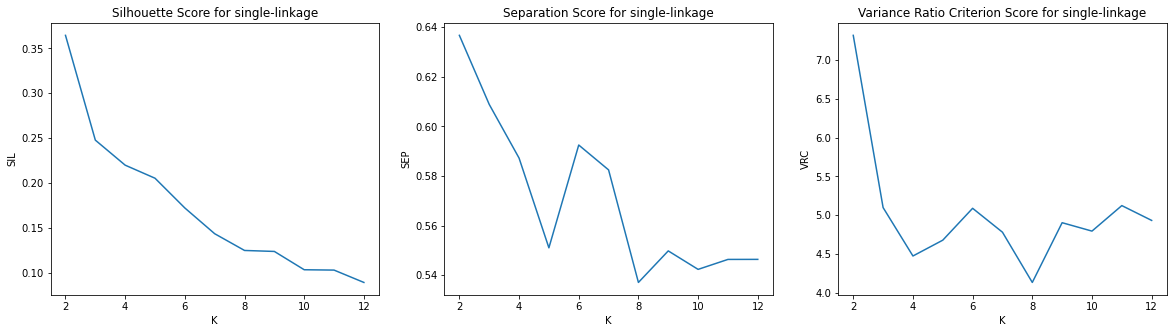

In [86]:
interpret_dendogram('single')

In [87]:
compute_cophenetic_correlation_coefficient("single")

cophenetic_correlation_coefficient	0.5002908426156896


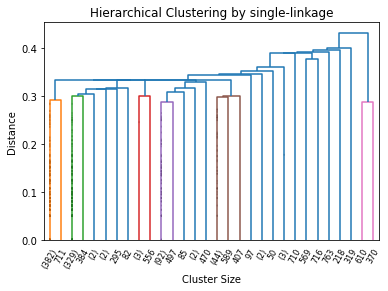

In [88]:
# We plot the dendrogram
cut_distance = 0.48
plot_dendrogram(model_single, cut_distance, "single-linkage", truncate_mode='lastp', p=30, leaf_rotation=60, 
                leaf_font_size = 8, show_contracted=True)

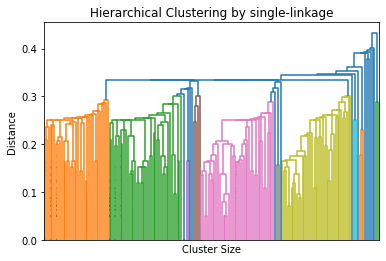

In [89]:
# We plot the dendrogram
cut_distance = 0.48
plot_dendrogram(model_single, cut_distance, "single-linkage", truncate_mode='level', p=30, no_labels=True,
                leaf_rotation=60, leaf_font_size = 8, show_contracted=True)

The single-linkage agglomerative clustering suggests the presence of 3 main cluster, being the result of the merging process of 3 subclusters, one composed by 878 points, the second composed by a 2 points end the third by one. As we can notice the first cluster is clumped together, due to the presence of noisy points and small dissimilarities among them, resulting in their merge.

<h6> The Farthest Point Algorithm: complete-linkage </h6>
It is based on the complete (Max) linkage, measuring the proximity of two clusters by the distance of their fartherst points.

Being more <b>resistant to outliers and noise</b>, the complete-linkage should prove more reliable than the single one. However, one drowback is to <b>break the larger clusters into smaller globular ones</b>.

In [90]:
# We want to compute the entire tree
model_complete = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', 
                                                                         linkage='complete').fit(df_probe)

Cluster numbers:  2
Cluster {0: 792, 1: 89}
Silhouette Score 0.22643690702425315
Separation Score 1.8265743881179086
Variance Ratio Criterion Score 92.03616988566127
Cluster numbers:  3
Cluster {0: 708, 1: 89, 2: 84}
Silhouette Score 0.21254466880675088
Separation Score 1.5883378416951965
Variance Ratio Criterion Score 135.74756164402885
Cluster numbers:  4
Cluster {0: 89, 1: 598, 2: 84, 3: 110}
Silhouette Score 0.13869304387664985
Separation Score 1.6361707193160988
Variance Ratio Criterion Score 130.71141574157897
Cluster numbers:  5
Cluster {0: 598, 1: 65, 2: 84, 3: 110, 4: 24}
Silhouette Score 0.13065508145149646
Separation Score 1.5933426173663885
Variance Ratio Criterion Score 111.10645010181489
Cluster numbers:  6
Cluster {0: 65, 1: 377, 2: 84, 3: 110, 4: 24, 5: 221}
Silhouette Score 0.15541287414152638
Separation Score 1.587715996365012
Variance Ratio Criterion Score 136.56136323981133
Cluster numbers:  7
Cluster {0: 377, 1: 110, 2: 84, 3: 21, 4: 24, 5: 221, 6: 44}
Silhouette S

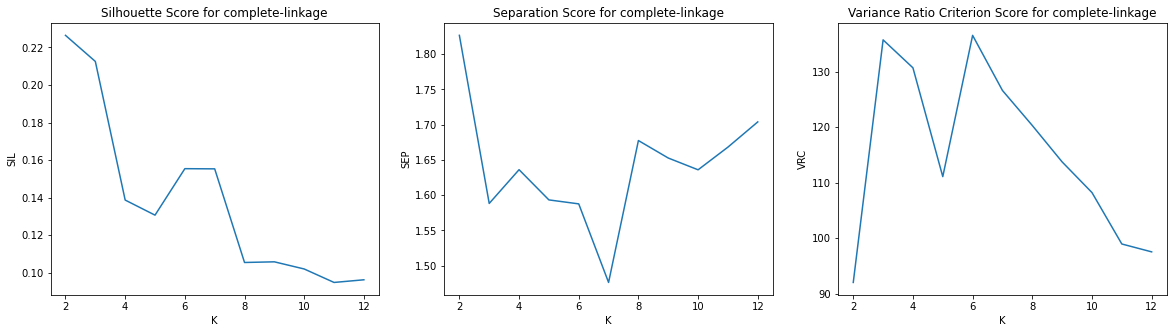

In [91]:
interpret_dendogram('complete')

In [92]:
compute_cophenetic_correlation_coefficient("complete")

cophenetic_correlation_coefficient	0.567677695851198


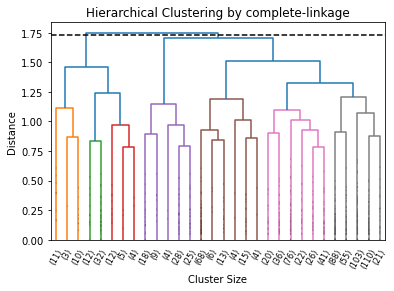

In [93]:
# We plot the dendrogram
cut_distance = 1.73
plot_dendrogram(model_complete, cut_distance, "complete-linkage", truncate_mode='lastp', 
                                                    p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True)

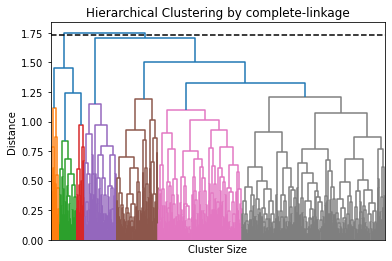

In [94]:
# We plot the dendrogram
cut_distance = 1.73
plot_dendrogram(model_complete, cut_distance, "complete-linkage", truncate_mode='level', p=30, leaf_rotation=60, 
                no_labels=True, leaf_font_size = 8, show_contracted=True)

The comple-linkage agglomerative clustering suggests the presence of 3 main cluster, being the result of the merging process of 3 main subclusters, the first composed by 708, the second by 84 points and the third by 84 points. As we can notice from the dendogram, usually these main clusters are the result of fragmented merged together subcluster (the drawback of comple-linkage is to break big clusters into smaller ones).

<h6> The UPGMA Algorithm: average-linkage </h6>
It stands as a <b>trade-off between the complete and single linkages</b>. The proximity of two clusters is the average of the pairwise proximity between the points of the two clusters.
As the complete linkage, it is <b>less susceptible to noise and outliers</b>, but it also tends to </b>prefer globular clusters</b>.

In [95]:
# We want to compute the entire tree
model_average = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', 
                                        linkage='average').fit(df_probe)

Cluster numbers:  2
Cluster {0: 813, 1: 68}
Silhouette Score 0.2756799062322022
Separation Score 1.4490730160799075
Variance Ratio Criterion Score 107.58431530533886
Cluster numbers:  3
Cluster {0: 68, 1: 706, 2: 107}
Silhouette Score 0.24710597376995022
Separation Score 1.3175424852853583
Variance Ratio Criterion Score 168.92259185769265
Cluster numbers:  4
Cluster {0: 706, 1: 55, 2: 107, 3: 13}
Silhouette Score 0.22893510472564454
Separation Score 1.3117283031891864
Variance Ratio Criterion Score 121.87752972240374
Cluster numbers:  5
Cluster {0: 48, 1: 55, 2: 107, 3: 13, 4: 658}
Silhouette Score 0.20355282341642555
Separation Score 1.275226754562693
Variance Ratio Criterion Score 125.69254440978416
Cluster numbers:  6
Cluster {0: 107, 1: 55, 2: 47, 3: 13, 4: 658, 5: 1}
Silhouette Score 0.19465215118887985
Separation Score 1.1411678384912782
Variance Ratio Criterion Score 101.36503411654135
Cluster numbers:  7
Cluster {0: 55, 1: 13, 2: 47, 3: 104, 4: 658, 5: 1, 6: 3}
Silhouette Score

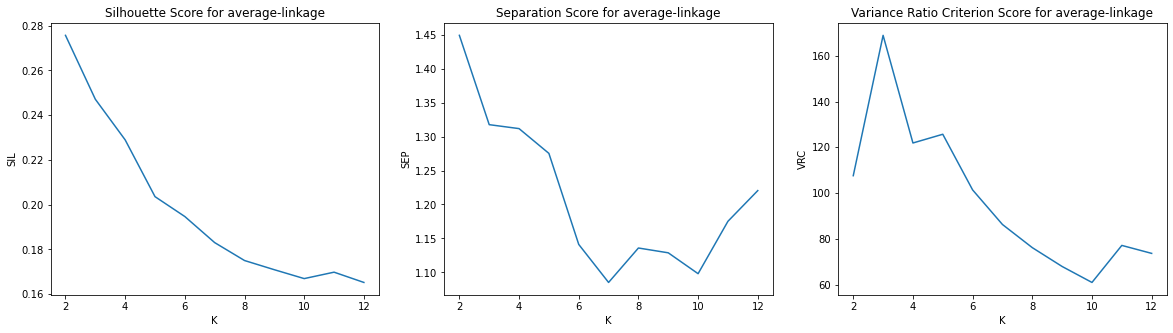

In [96]:
interpret_dendogram('average')

In [97]:
compute_cophenetic_correlation_coefficient("average")

cophenetic_correlation_coefficient	0.6888096149689895


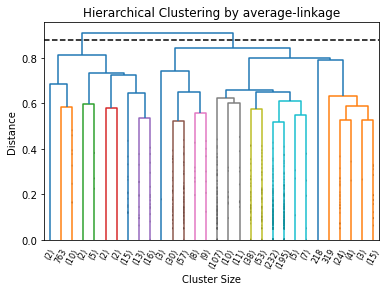

In [98]:
cut_distance = 0.88
plot_dendrogram(model_average, cut_distance, "average-linkage", truncate_mode='lastp',
                p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True)

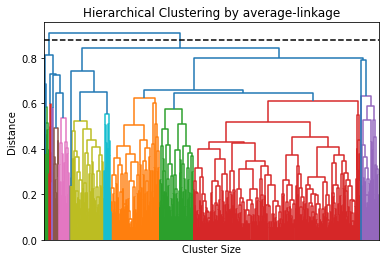

In [99]:
cut_distance = 0.88
plot_dendrogram(model_average, cut_distance, "average-linkage", truncate_mode='level', p=30, 
                leaf_rotation=60, leaf_font_size = 8, no_labels=True, show_contracted=True)

The average-linkage agglomerative clustering suggests the presence of 3 main cluster, being the result of the merging process of 3 main subclusters, one composed by 107 points, the second by 706 points and the third by 68 points. 
Since it is a trade-off between the complete and single linkages, we can again see how it is susceptile to noise, noticing, however, that the subclusters are less clumped together. 

<h6> The Incremental Algorithm: ward-linkage </h6>
It stands as the hierarchical <b>analogue of K-means</b> and, like the former, it is a <b>centroid based approach</b> with a particular interest in the minimization of the SSE values associated with each cluster.

In [100]:
# We want to compute the entire tree
model_ward = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', 
                                     linkage='ward').fit(df_probe)

Cluster numbers:  2
Cluster {0: 734, 1: 147}
Silhouette Score 0.274893020569175
Separation Score 1.3511108205145224
Variance Ratio Criterion Score 222.88659318877433
Cluster numbers:  3
Cluster {0: 266, 1: 147, 2: 468}
Silhouette Score 0.22974386936871594
Separation Score 1.5828142372796126
Variance Ratio Criterion Score 238.30766243465212
Cluster numbers:  4
Cluster {0: 468, 1: 147, 2: 109, 3: 157}
Silhouette Score 0.1972662287132757
Separation Score 1.5690845912677847
Variance Ratio Criterion Score 210.84580652745714
Cluster numbers:  5
Cluster {0: 420, 1: 147, 2: 109, 3: 157, 4: 48}
Silhouette Score 0.20792006295193532
Separation Score 1.4409273821500417
Variance Ratio Criterion Score 204.59327627189649
Cluster numbers:  6
Cluster {0: 147, 1: 195, 2: 109, 3: 157, 4: 48, 5: 225}
Silhouette Score 0.18808662394872444
Separation Score 1.4794753537695442
Variance Ratio Criterion Score 199.45458333430332
Cluster numbers:  7
Cluster {0: 109, 1: 195, 2: 225, 3: 157, 4: 48, 5: 93, 6: 54}
Sil

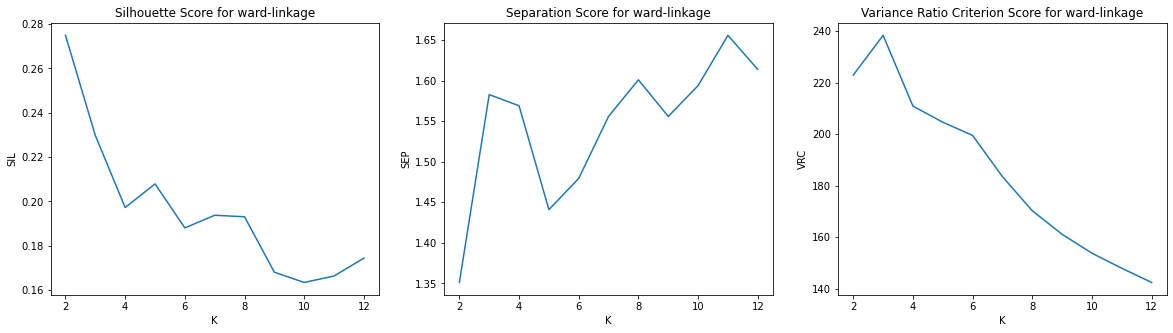

In [101]:
interpret_dendogram('ward')

In [102]:
compute_cophenetic_correlation_coefficient("ward")

cophenetic_correlation_coefficient	0.56658430842308


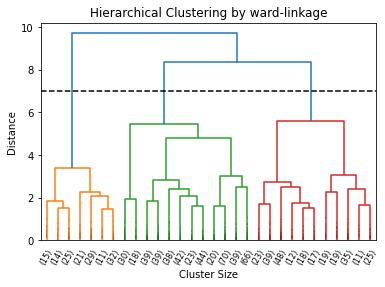

In [103]:
# We plot the dendrogram
cut_distance = 7.0
plot_dendrogram(model_ward, cut_distance, "ward-linkage", truncate_mode='lastp', 
                p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True)

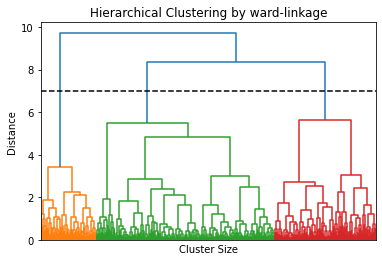

In [104]:
# We plot the dendrogram
cut_distance = 7.0
plot_dendrogram(model_ward, cut_distance, "ward-linkage", truncate_mode='level', p=30, 
                leaf_rotation=60, leaf_font_size = 8, no_labels=True, show_contracted=True)

Since this linkage metric used to merged similar cluster best resembles the K-Means, we expected a correspondence with the best k previously evaluate with the Elbow and Silhouette Methods. Here, the dendrogram seems to suggest the presence of 3 main clusters, a larger one (468) and two smaller ones (147 and 266 points). 

Therefore ward-linkage's best cut confirms the best k evaluated for K-Means.
Above and bellow the dendogram we can found other k candidates used for K-Means, too: k=2, k=5, k=6, and k=7. Also clusters' cardinality among the two clustering methods are essentially identical (471, 265 and 147 points for K-Means for k=3).

<h6> Best linkage function selection </h6>
In our opinion the best linkage fucntion for our dataset is the <b>ward-linkage</b>. We will be less restrictive with the cut_off level in our analysis, using k=2, k=3, k=4 (as suggest by the dendogram) and a k=5 from graphical inspection. These choises are a validatation and a conforn with K-Means values, too.

<h2>k=3</h2>

In [105]:
k = 3
cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')  
cluster.fit_predict(df_probe)
cluster_label = str(k) + "cluster_label"
df_num[cluster_label] = cluster.labels_  # retrieve points cluster label of appartenence 
df_impunted[cluster_label] = cluster.labels_  # retrieve points cluster label of appartenence 

<h6> Contincengy matrixes </h6>
A contincengy matrix is a 2x2 matrix having the followinf format:

|  | Same Cluster | Different clusters |
| --- | --- | --- |
| Same Class  | f11 | f10 |
| Different Class | f01 | f00 |

where:
- f11 = number of elements of given class in examinated cluster;
- f10 = number of elements of given class in other clusters;
- f01 = number of elements of other classes in examinated cluster;
- f00 = number of elements of other classes in other clusters.

With the contincengy matrix we can derive useful external indexes to validate cluster's goodness:
- $$Jaccard similarity = \dfrac{f11}{f11 + f10 + f01}$$
- $$F1 measure = \dfrac{2*precision*recall}{precision + recall}$$
 with:
 - $$precision = \dfrac{f11}{f11 + f01}$$
 - $$recall = \dfrac{f11}{f11 + f10}$$

In [106]:
clust = 0
f11 = df_impunted[(df_impunted[cluster_label] == clust) & (df_impunted["Attrition"] == "Yes")].shape[0]
f10 = df_impunted[(df_impunted[cluster_label] == clust) & (df_impunted["Attrition"] == "No")].shape[0]
f01 = df_impunted[(df_impunted[cluster_label] != clust) & (df_impunted["Attrition"] == "Yes")].shape[0]
f00 = df_impunted[(df_impunted[cluster_label] != clust) & (df_impunted["Attrition"] == "No")].shape[0]

print("Contingency table for clust " + str(clust))
print(f11, f01, sep="\t")
print(f10, f00, sep="\t")

rand = (f00 + f01) / (f00 + f01 + f10 + f11)
jaccard = f11 / (f11 + f10 + f01)
precision = f11 / (f11 + f10)
recall = f11 / (f11 + f01)
f_measure = (2*precision*recall) / (precision + recall)
print("Rand statistic = ", rand)
print("Jaccard coefficient = ", jaccard)
print("F-measure = ", f_measure)

Contingency table for clust 0
26	126
240	489
Rand statistic =  0.6980703745743473
Jaccard coefficient =  0.0663265306122449
F-measure =  0.12440191387559806


In [107]:
clust = 1
f11 = df_impunted[(df_impunted[cluster_label] == clust) & (df_impunted["Attrition"] == "Yes")].shape[0]
f10 = df_impunted[(df_impunted[cluster_label] == clust) & (df_impunted["Attrition"] == "No")].shape[0]
f01 = df_impunted[(df_impunted[cluster_label] != clust) & (df_impunted["Attrition"] == "Yes")].shape[0]
f00 = df_impunted[(df_impunted[cluster_label] != clust) & (df_impunted["Attrition"] == "No")].shape[0]

print("Contingency table for clust " + str(clust))
print(f11, f01, sep="\t")
print(f10, f00, sep="\t")

rand = (f00 + f01) / (f00 + f01 + f10 + f11)
jaccard = f11 / (f11 + f10 + f01)
precision = f11 / (f11 + f10)
recall = f11 / (f11 + f01)
f_measure = (2*precision*recall) / (precision + recall)
print("Rand statistic = ", rand)
print("Jaccard coefficient = ", jaccard)
print("F-measure = ", f_measure)

Contingency table for clust 1
17	135
130	599
Rand statistic =  0.8331441543700341
Jaccard coefficient =  0.06028368794326241
F-measure =  0.11371237458193979


In [108]:
clust = 2
f11 = df_impunted[(df_impunted[cluster_label] == clust) & (df_impunted["Attrition"] == "Yes")].shape[0]
f10 = df_impunted[(df_impunted[cluster_label] == clust) & (df_impunted["Attrition"] == "No")].shape[0]
f01 = df_impunted[(df_impunted[cluster_label] != clust) & (df_impunted["Attrition"] == "Yes")].shape[0]
f00 = df_impunted[(df_impunted[cluster_label] != clust) & (df_impunted["Attrition"] == "No")].shape[0]

print("Contingency table for clust " + str(clust))
print(f11, f01, sep="\t")
print(f10, f00, sep="\t")

rand = (f00 + f01) / (f00 + f01 + f10 + f11)
jaccard = f11 / (f11 + f10 + f01)
precision = f11 / (f11 + f10)
recall = f11 / (f11 + f01)
f_measure = (2*precision*recall) / (precision + recall)
print("Rand statistic = ", rand)
print("Jaccard coefficient = ", jaccard)
print("F-measure = ", f_measure)

Contingency table for clust 2
109	43
359	370
Rand statistic =  0.46878547105561863
Jaccard coefficient =  0.21330724070450097
F-measure =  0.3516129032258064


<h6> Clusters characterisation </h6>

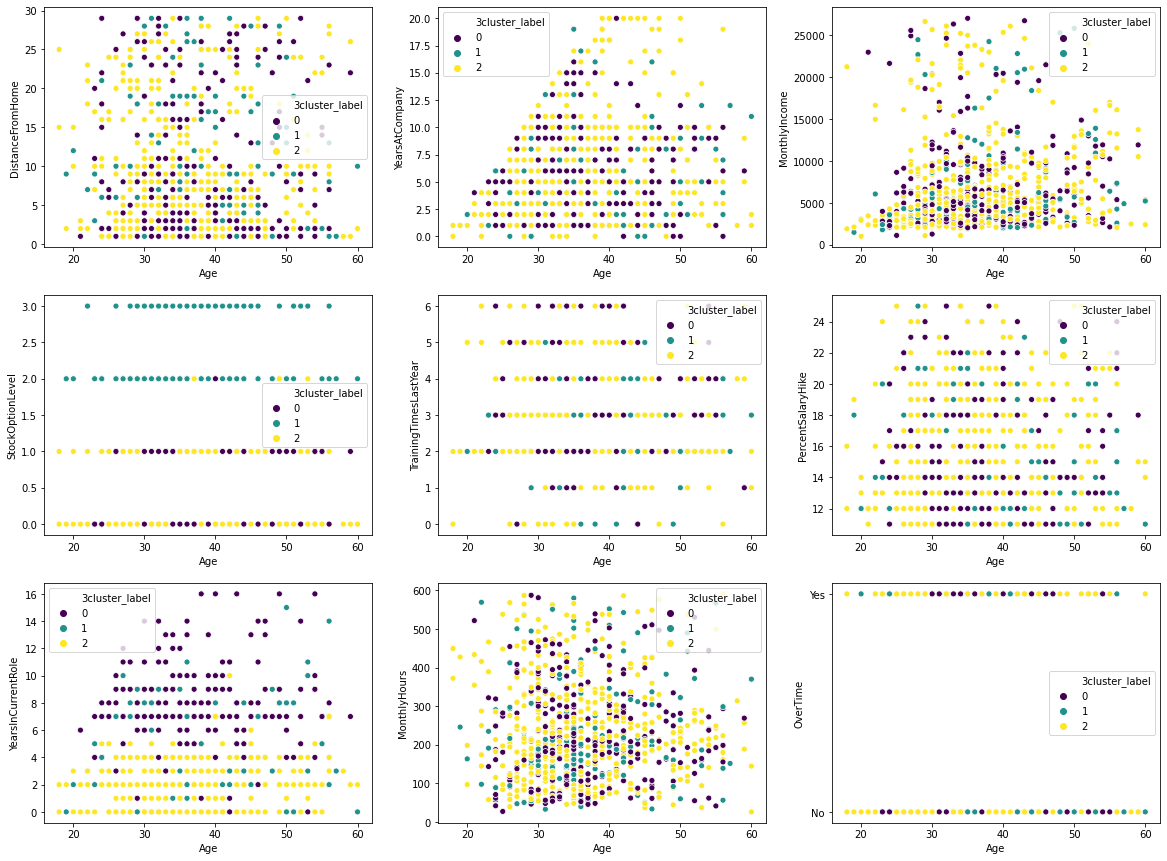

In [109]:
curr_column = "Age"
fig =plt.subplots(figsize=(20, 15))
fig_dims = (3, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns.scatterplot(df_impunted[curr_column], df_impunted['DistanceFromHome'], 
                                                                hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (0, 1))
sns.scatterplot(df_impunted[curr_column], df_impunted['YearsAtCompany'], 
                                                                hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (0, 2))
sns.scatterplot(df_impunted[curr_column], df_impunted['MonthlyIncome'], 
                                                                hue=df_num[cluster_label], palette="viridis")  

ax = plt.subplot2grid(fig_dims, (1, 0))
sns.scatterplot(df_impunted[curr_column], df_impunted['StockOptionLevel'], 
                                                                hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (1, 1))
sns.scatterplot(df_impunted[curr_column], df_impunted['TrainingTimesLastYear'], 
                                                                 hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (1, 2))
sns.scatterplot(df_impunted[curr_column], df_impunted['PercentSalaryHike'], 
                                                                hue=df_num[cluster_label], palette="viridis")  

ax = plt.subplot2grid(fig_dims, (2, 0))
sns.scatterplot(df_impunted[curr_column], df_impunted['YearsInCurrentRole'], 
                                                             hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (2, 1))
sns.scatterplot(df_impunted[curr_column], df_impunted['MonthlyHours'], 
                                                            hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (2, 2))
sns.scatterplot(df_impunted[curr_column], df_impunted['OverTime'], 
                                                            hue=df_num[cluster_label], palette="viridis")  

plt.show()

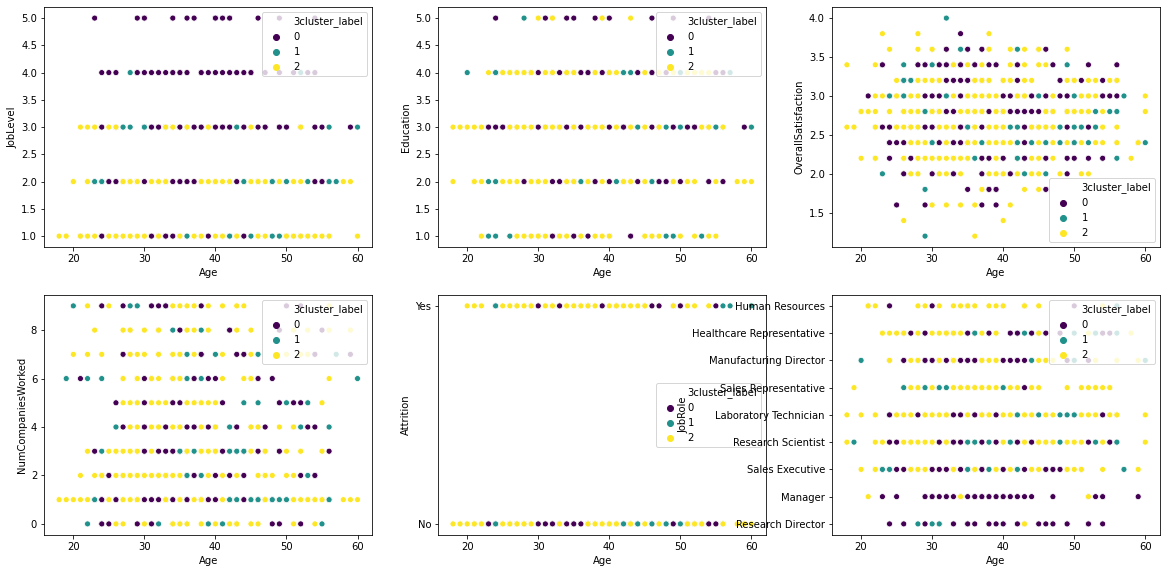

In [110]:
curr_column = "Age"
fig =plt.subplots(figsize=(20, 15))
fig_dims = (3, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns.scatterplot(df_impunted[curr_column], df_impunted['JobLevel'], 
                                                            hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (0, 1))
sns.scatterplot(df_impunted[curr_column], df_impunted['Education'], 
                                                            hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (0, 2))
sns.scatterplot(df_impunted[curr_column], df_impunted['OverallSatisfaction'], 
                                                            hue=df_num[cluster_label], palette="viridis")  

ax = plt.subplot2grid(fig_dims, (1, 0))
sns.scatterplot(df_impunted[curr_column], df_impunted['NumCompaniesWorked'], 
                                                            hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (1, 1))
sns.scatterplot(df_impunted[curr_column], df_impunted['Attrition'], 
                                                            hue=df_num[cluster_label], palette="viridis") 

ax = plt.subplot2grid(fig_dims, (1, 2))
sns.scatterplot(df_impunted[curr_column], df_impunted['JobRole'], 
                                                            hue=df_num[cluster_label], palette="viridis") 

plt.show()

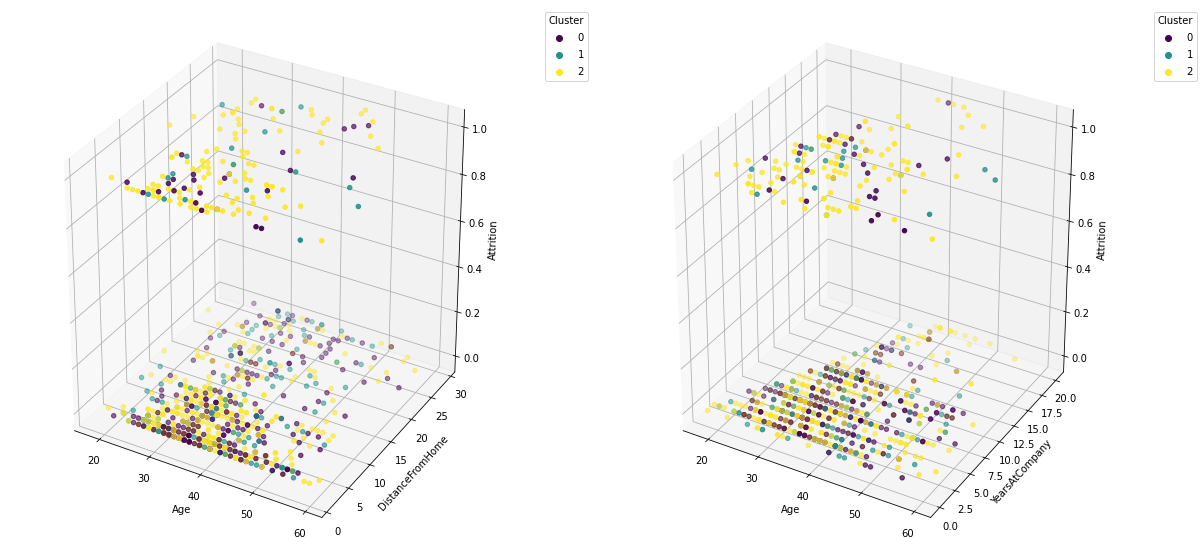

In [111]:
plot_3d_scatterplot(df_impunted, 'Age', 'DistanceFromHome', 'YearsAtCompany', True)

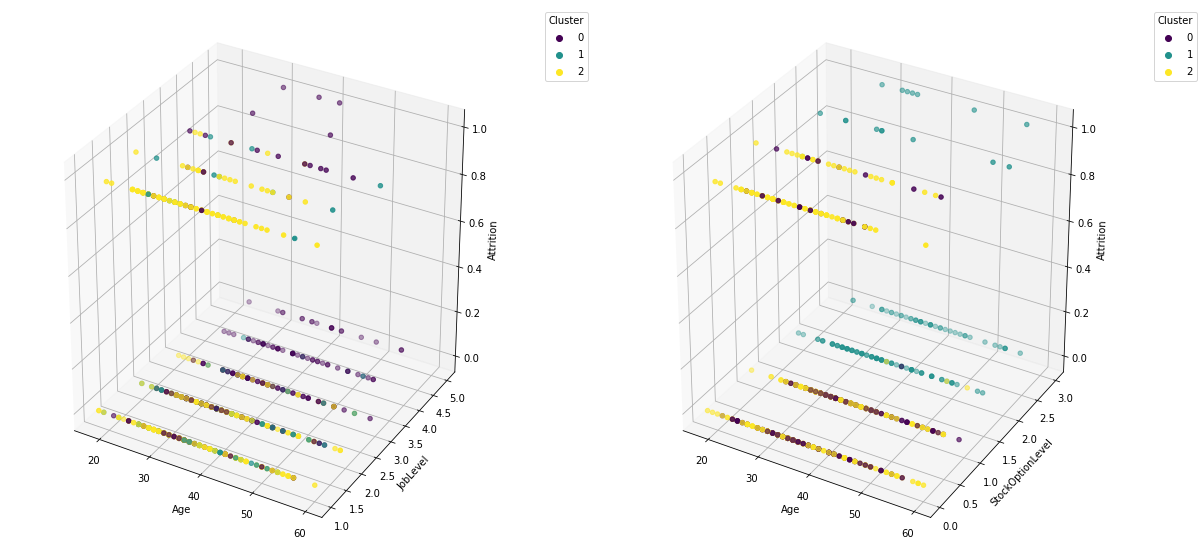

In [112]:
plot_3d_scatterplot(df_impunted, 'Age', 'JobLevel', 'StockOptionLevel', True)

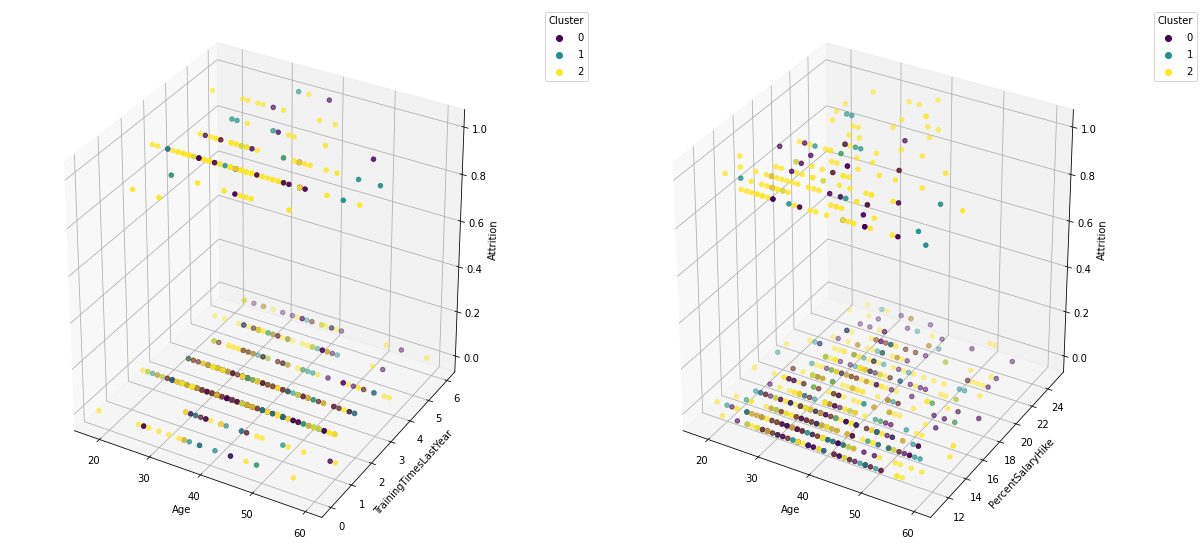

In [113]:
plot_3d_scatterplot(df_impunted, 'Age', 'TrainingTimesLastYear', 'PercentSalaryHike', True)

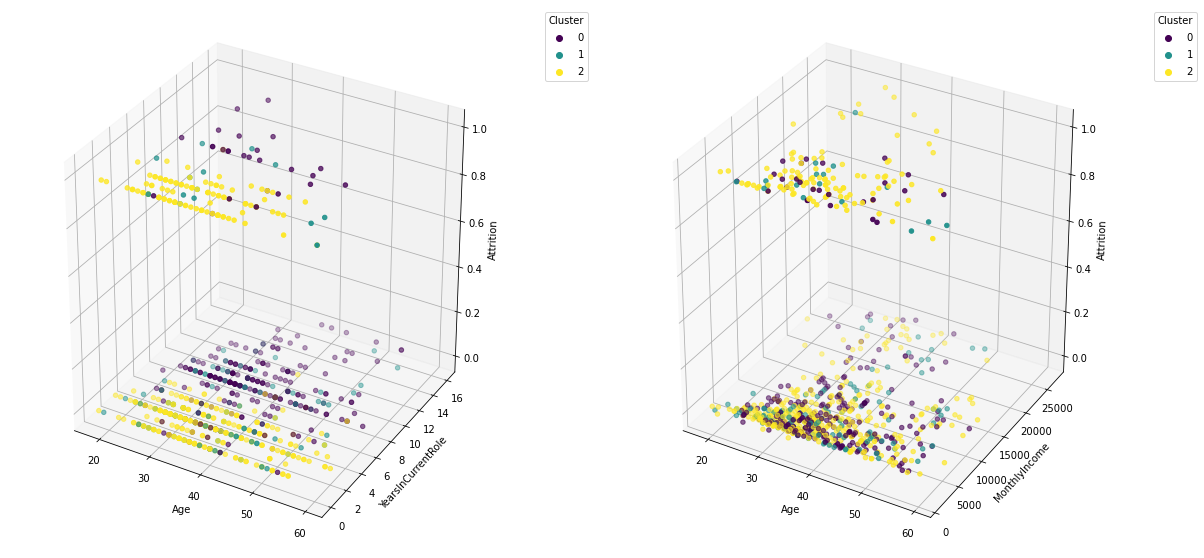

In [114]:
plot_3d_scatterplot(df_impunted, 'Age', 'YearsInCurrentRole', 'MonthlyIncome', True)

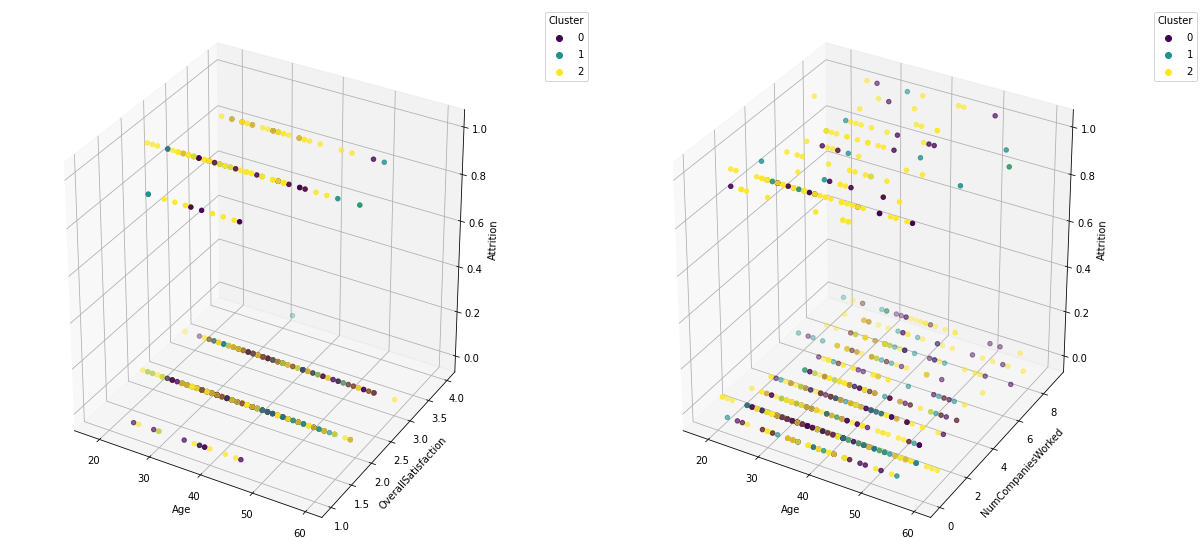

In [115]:
plot_3d_scatterplot(df_impunted, 'Age', 'OverallSatisfaction', 'NumCompaniesWorked', True)

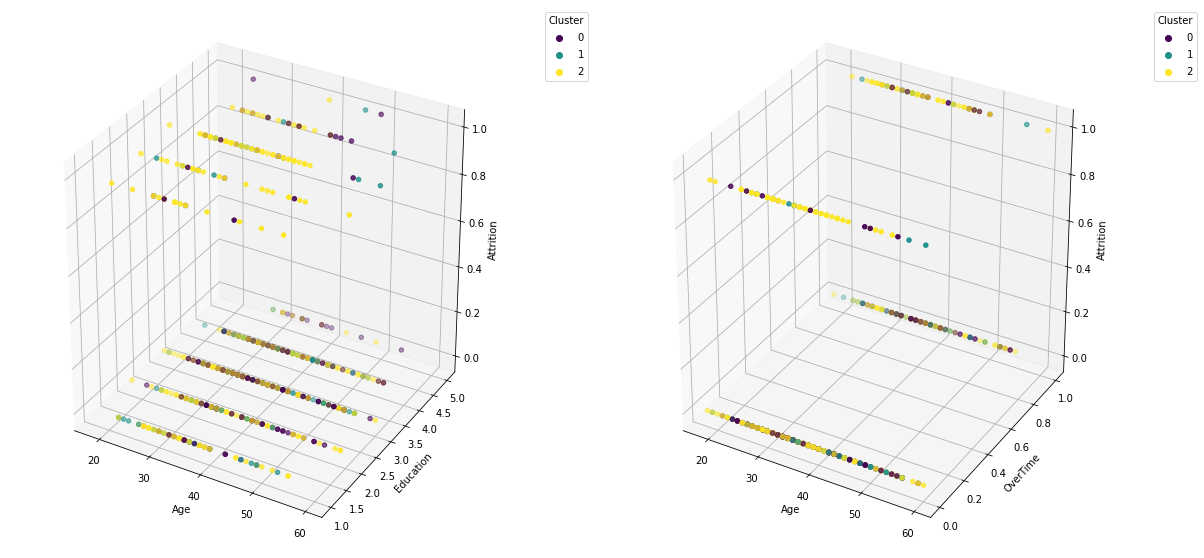

In [116]:
plot_3d_scatterplot(df_impunted, 'Age', 'Education', 'OverTime', True)

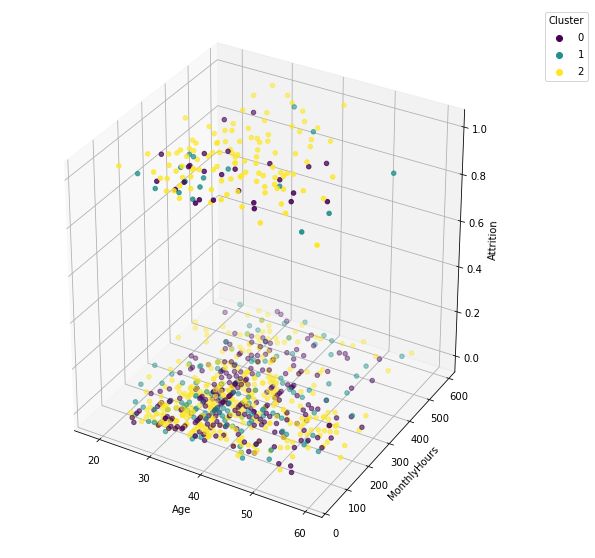

In [117]:
plot_3d_scatterplot(df_impunted, 'Age', 'MonthlyHours', "", False)

In [118]:
df_impunted[(df_impunted[cluster_label] == 0)].shape[0]

266

In [119]:
df_impunted[(df_impunted[cluster_label] == 0) & (df_impunted["Attrition"] == "Yes")].shape[0]

26

In [120]:
df_impunted[(df_impunted[cluster_label] == 1)].shape[0]

147

In [121]:
df_impunted[(df_impunted[cluster_label] == 1) & (df_impunted["Attrition"] == "Yes")].shape[0]

17

In [122]:
df_impunted[(df_impunted[cluster_label] == 2)].shape[0]

468

In [123]:
df_impunted[(df_impunted[cluster_label] == 2) & (df_impunted["Attrition"] == "Yes")].shape[0]

109

With k=3 we are able to identintify the group of all leaving employees, without any noise.

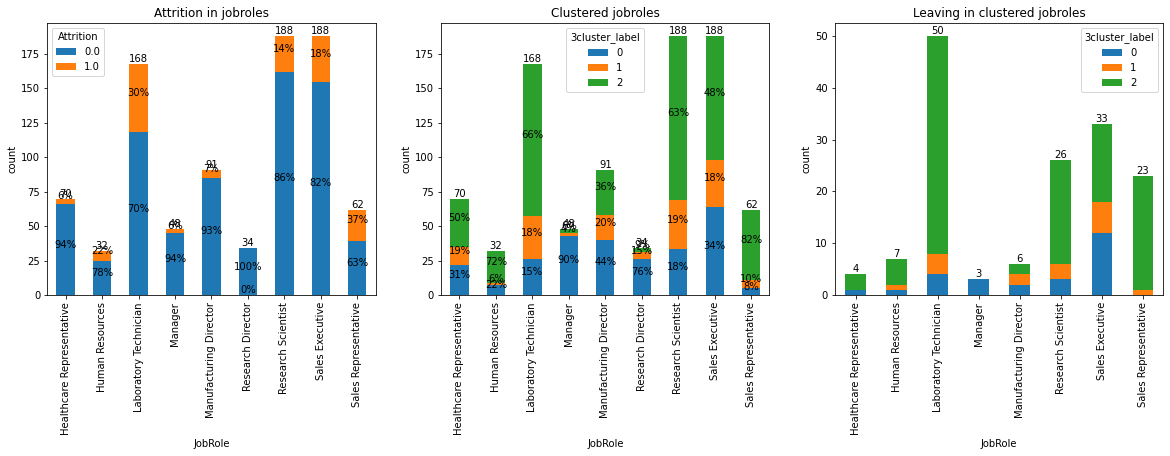

In [124]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "Attrition", df_impunted, df_num, True, ax, 90, "", "", "Attrition in jobroles")
ax = plt.subplot2grid(fig_dims, (0, 1))
draw_stacked_bar(curr_column, cluster_label, df_impunted,  df_num, True, ax, 90, "", "", "Clustered jobroles")
ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, cluster_label, df_impunted[df_impunted["Attrition"] == "Yes"], 
                 df_num[df_num["Attrition"] == 1], False, ax, 90, "", "", "Leaving in clustered jobroles")

<h6> Cluster 0 insight </h6>

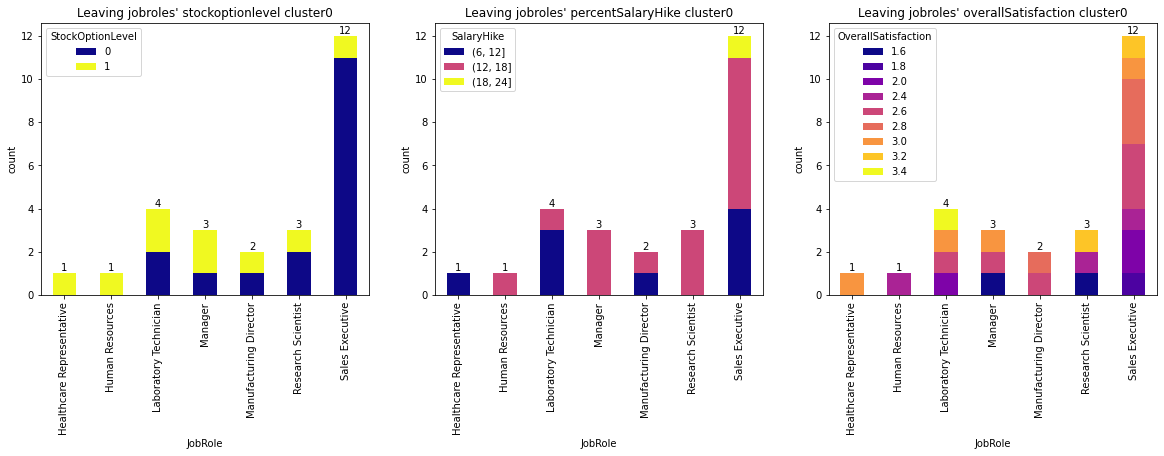

In [125]:
curr_column = "JobRole"
curr_cluster = 0
curr_cmap = "plasma"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "StockOptionLevel", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"]=="Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' stockoptionlevel cluster" + str(curr_cluster))
 
ax = plt.subplot2grid(fig_dims, (0, 1))
df_hike = df_impunted.copy()
df_hike["SalaryHike"] = pd.cut(x=df_impunted["PercentSalaryHike"], bins=[6, 12, 18, 24])
draw_stacked_bar(curr_column, "SalaryHike", 
                 df_impunted[(df_impunted["Attrition"]=="Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_hike[(df_hike["Attrition"]=="Yes") & (df_hike[cluster_label]==curr_cluster)], 
                 False, ax, 90, "",curr_cmap, "Leaving jobroles' percentSalaryHike cluster" + str(curr_cluster))
ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, "OverallSatisfaction", 
                 df_impunted[(df_impunted["Attrition"]=="Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' overallSatisfaction cluster" + str(curr_cluster))

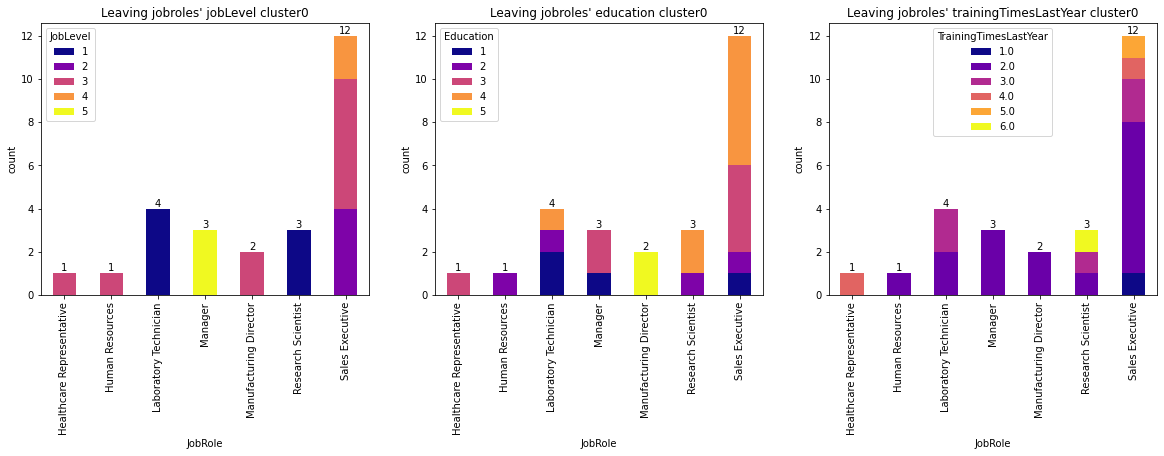

In [126]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "JobLevel", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)],
                False, ax, 90, "", curr_cmap, "Leaving jobroles' jobLevel cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 1))
draw_stacked_bar(curr_column, "Education", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                False, ax, 90, "", curr_cmap, "Leaving jobroles' education cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, "TrainingTimesLastYear", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
    False, ax, 90, "upper center", curr_cmap, "Leaving jobroles' trainingTimesLastYear cluster" + str(curr_cluster))

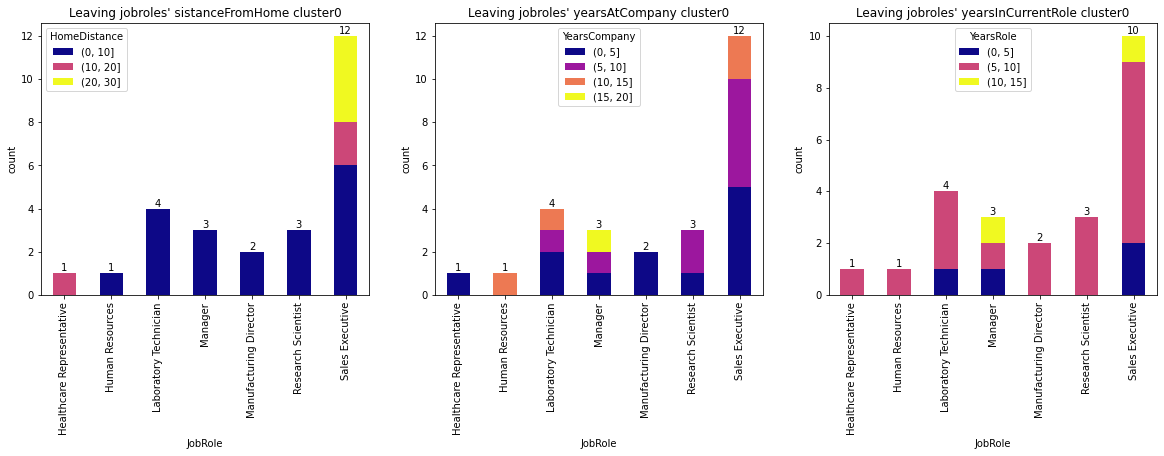

In [127]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
df_dist = df_impunted.copy()
df_dist["HomeDistance"] = pd.cut(x=df_impunted["DistanceFromHome"], bins=[0, 10, 20, 30])
draw_stacked_bar(curr_column, "HomeDistance", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_dist[(df_dist["Attrition"] == "Yes") & (df_dist[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' sistanceFromHome cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 1))
df_yc = df_impunted.copy()
df_yc["YearsCompany"] = pd.cut(x=df_impunted["YearsAtCompany"], bins=[0, 5, 10, 15, 20, 25, 30, 35, 40])
draw_stacked_bar(curr_column, "YearsCompany", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_yc[(df_yc["Attrition"] == "Yes") & (df_yc[cluster_label]==curr_cluster)], 
         False, ax, 90, "upper center", curr_cmap, "Leaving jobroles' yearsAtCompany cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 2))
df_yr = df_impunted.copy()
df_yr["YearsRole"] = pd.cut(x=df_impunted["YearsInCurrentRole"], bins=[0, 5, 10, 15, 20, 25, 30, 35, 40])
draw_stacked_bar(curr_column, "YearsRole", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_yr[(df_yr["Attrition"] == "Yes") & (df_yr[cluster_label]==curr_cluster)], 
    False, ax, 90, "upper center", curr_cmap, "Leaving jobroles' yearsInCurrentRole cluster" + str(curr_cluster))

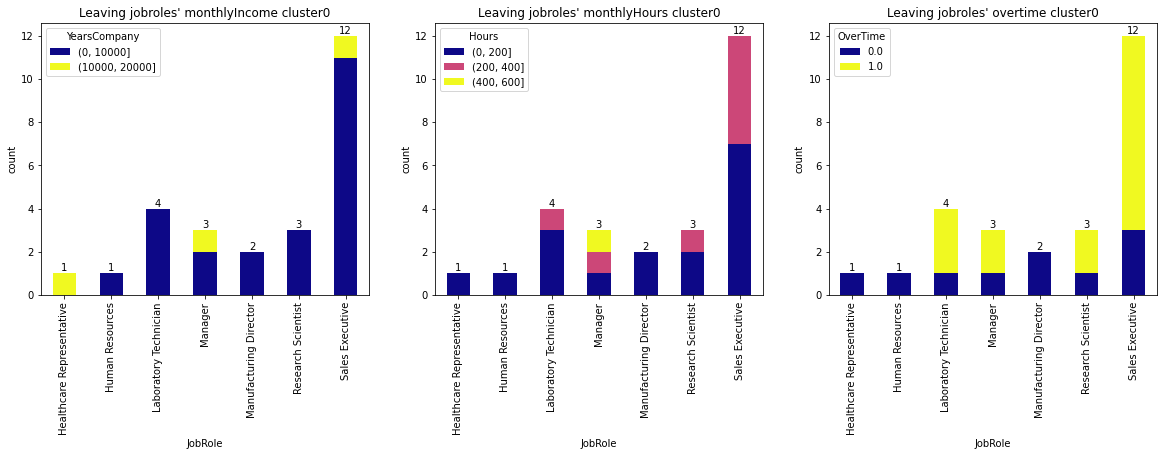

In [128]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
df_income = df_impunted.copy()
df_income["YearsCompany"] = pd.cut(x=df_impunted["MonthlyIncome"], bins=[0, 10000, 20000, 30000])
draw_stacked_bar(curr_column, "YearsCompany", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_income[(df_income["Attrition"] == "Yes") & (df_income[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' monthlyIncome cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 1))
df_h = df_impunted.copy()
df_h["Hours"] = pd.cut(x=df_impunted["MonthlyHours"], bins=[0, 200, 400, 600, 800, 1000])
draw_stacked_bar(curr_column, "Hours",
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_h[(df_h["Attrition"] == "Yes") & (df_h[cluster_label]==curr_cluster)],
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' monthlyHours cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, "OverTime", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_num[(df_num["Attrition"] == 1) & (df_num[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' overtime cluster" + str(curr_cluster))

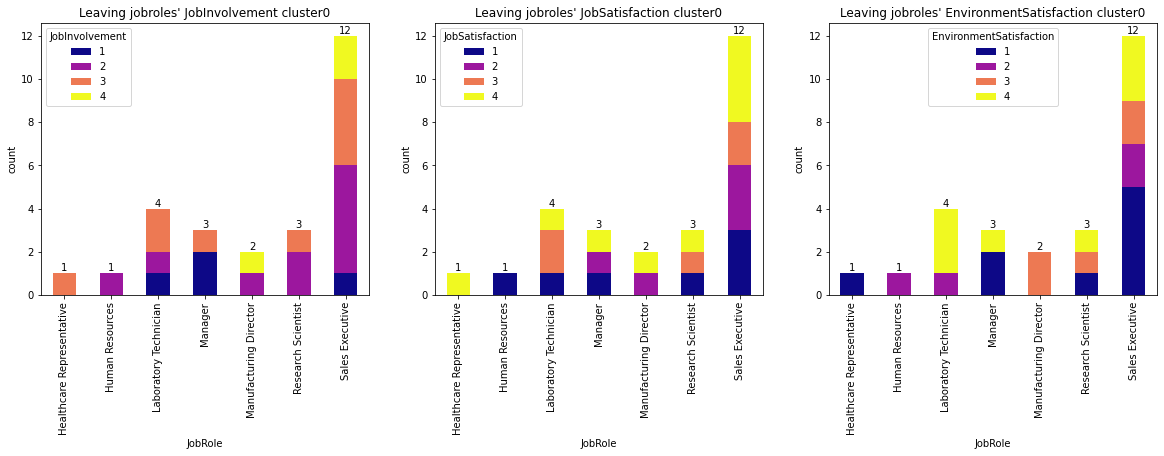

In [129]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "JobInvolvement", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap,
                                                 "Leaving jobroles' JobInvolvement cluster" + str(curr_cluster))
ax = plt.subplot2grid(fig_dims, (0, 1))
draw_stacked_bar(curr_column, "JobSatisfaction", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)],
                 False, ax, 90, "", curr_cmap,
                                            "Leaving jobroles' JobSatisfaction cluster" + str(curr_cluster))
ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, "EnvironmentSatisfaction", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "upper center", curr_cmap,
                                         "Leaving jobroles' EnvironmentSatisfaction cluster" + str(curr_cluster))

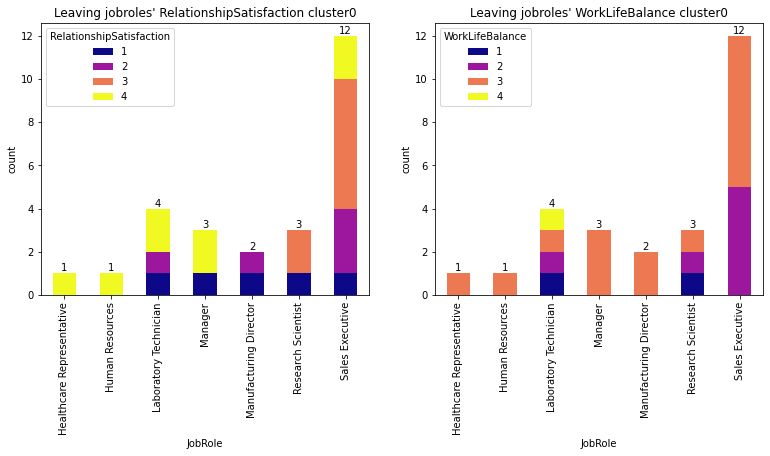

In [130]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "RelationshipSatisfaction", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap,
                                "Leaving jobroles' RelationshipSatisfaction cluster" + str(curr_cluster))
ax = plt.subplot2grid(fig_dims, (0, 1))
draw_stacked_bar(curr_column, "WorkLifeBalance", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)],
                 False, ax, 90, "", curr_cmap,
                                         "Leaving jobroles' WorkLifeBalance cluster" + str(curr_cluster))

<h6> Cluster 1 insight </h6>

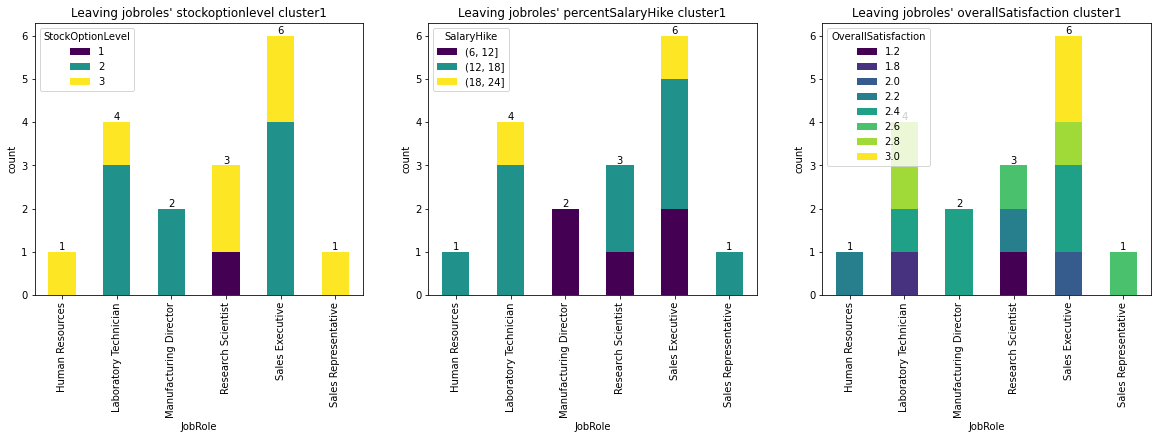

In [131]:
curr_column = "JobRole"
curr_cluster = 1
curr_cmap = "viridis"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "StockOptionLevel", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"]=="Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' stockoptionlevel cluster" + str(curr_cluster))
 
ax = plt.subplot2grid(fig_dims, (0, 1))
df_hike = df_impunted.copy()
df_hike["SalaryHike"] = pd.cut(x=df_impunted["PercentSalaryHike"], bins=[6, 12, 18, 24])
draw_stacked_bar(curr_column, "SalaryHike", 
                 df_impunted[(df_impunted["Attrition"]=="Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_hike[(df_hike["Attrition"]=="Yes") & (df_hike[cluster_label]==curr_cluster)], 
                 False, ax, 90, "",curr_cmap, "Leaving jobroles' percentSalaryHike cluster" + str(curr_cluster))
ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, "OverallSatisfaction", 
                 df_impunted[(df_impunted["Attrition"]=="Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' overallSatisfaction cluster" + str(curr_cluster))

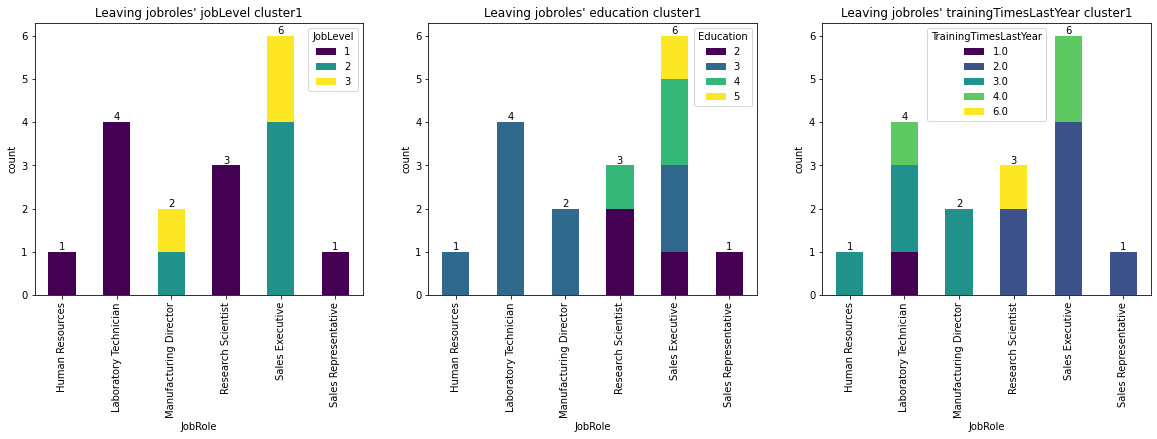

In [132]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "JobLevel", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)],
                False, ax, 90, "", curr_cmap, "Leaving jobroles' jobLevel cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 1))
draw_stacked_bar(curr_column, "Education", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                False, ax, 90, "", curr_cmap, "Leaving jobroles' education cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, "TrainingTimesLastYear", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
    False, ax, 90, "upper center", curr_cmap, "Leaving jobroles' trainingTimesLastYear cluster" + str(curr_cluster))

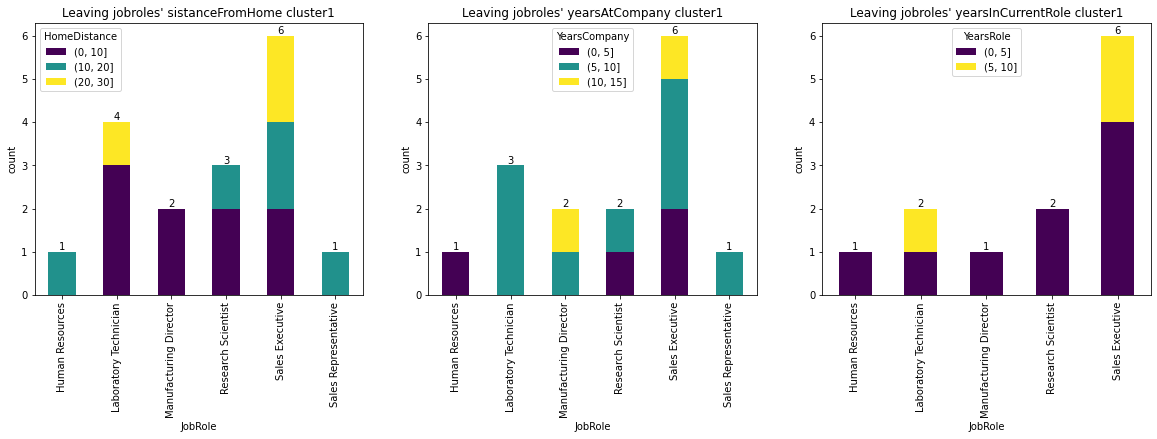

In [133]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
df_dist = df_impunted.copy()
df_dist["HomeDistance"] = pd.cut(x=df_impunted["DistanceFromHome"], bins=[0, 10, 20, 30])
draw_stacked_bar(curr_column, "HomeDistance", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_dist[(df_dist["Attrition"] == "Yes") & (df_dist[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' sistanceFromHome cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 1))
df_yc = df_impunted.copy()
df_yc["YearsCompany"] = pd.cut(x=df_impunted["YearsAtCompany"], bins=[0, 5, 10, 15, 20, 25, 30, 35, 40])
draw_stacked_bar(curr_column, "YearsCompany", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_yc[(df_yc["Attrition"] == "Yes") & (df_yc[cluster_label]==curr_cluster)], 
         False, ax, 90, "upper center", curr_cmap, "Leaving jobroles' yearsAtCompany cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 2))
df_yr = df_impunted.copy()
df_yr["YearsRole"] = pd.cut(x=df_impunted["YearsInCurrentRole"], bins=[0, 5, 10, 15, 20, 25, 30, 35, 40])
draw_stacked_bar(curr_column, "YearsRole", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_yr[(df_yr["Attrition"] == "Yes") & (df_yr[cluster_label]==curr_cluster)], 
    False, ax, 90, "upper center", curr_cmap, "Leaving jobroles' yearsInCurrentRole cluster" + str(curr_cluster))

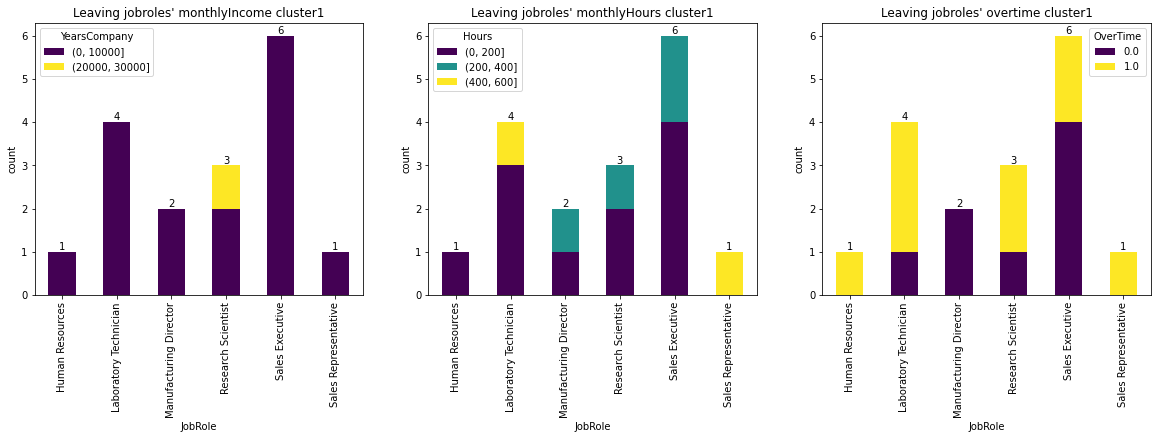

In [134]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
df_income = df_impunted.copy()
df_income["YearsCompany"] = pd.cut(x=df_impunted["MonthlyIncome"], bins=[0, 10000, 20000, 30000])
draw_stacked_bar(curr_column, "YearsCompany", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_income[(df_income["Attrition"] == "Yes") & (df_income[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' monthlyIncome cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 1))
df_h = df_impunted.copy()
df_h["Hours"] = pd.cut(x=df_impunted["MonthlyHours"], bins=[0, 200, 400, 600, 800, 1000])
draw_stacked_bar(curr_column, "Hours",
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_h[(df_h["Attrition"] == "Yes") & (df_h[cluster_label]==curr_cluster)],
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' monthlyHours cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, "OverTime", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_num[(df_num["Attrition"] == 1) & (df_num[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' overtime cluster" + str(curr_cluster))

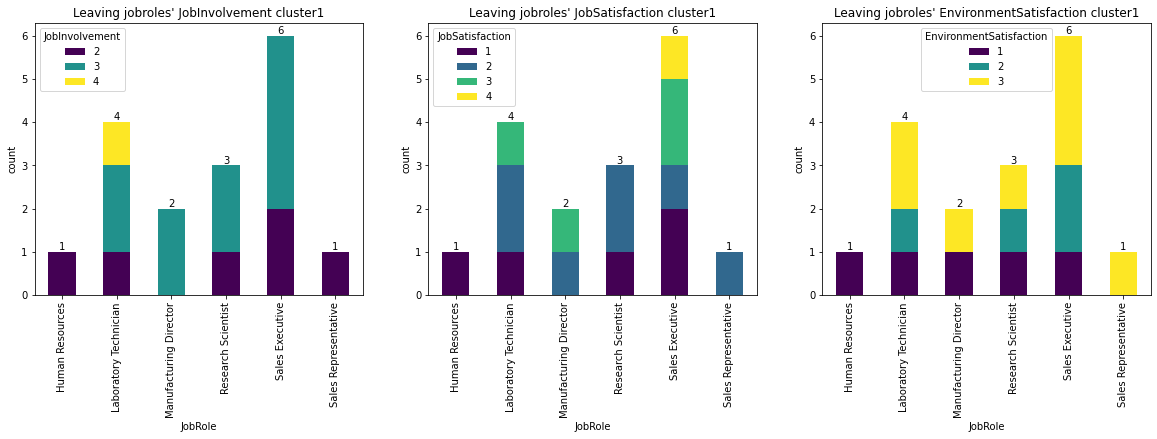

In [135]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "JobInvolvement", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap,
                                                 "Leaving jobroles' JobInvolvement cluster" + str(curr_cluster))
ax = plt.subplot2grid(fig_dims, (0, 1))
draw_stacked_bar(curr_column, "JobSatisfaction", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)],
                 False, ax, 90, "", curr_cmap,
                                            "Leaving jobroles' JobSatisfaction cluster" + str(curr_cluster))
ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, "EnvironmentSatisfaction", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "upper center", curr_cmap,
                                         "Leaving jobroles' EnvironmentSatisfaction cluster" + str(curr_cluster))

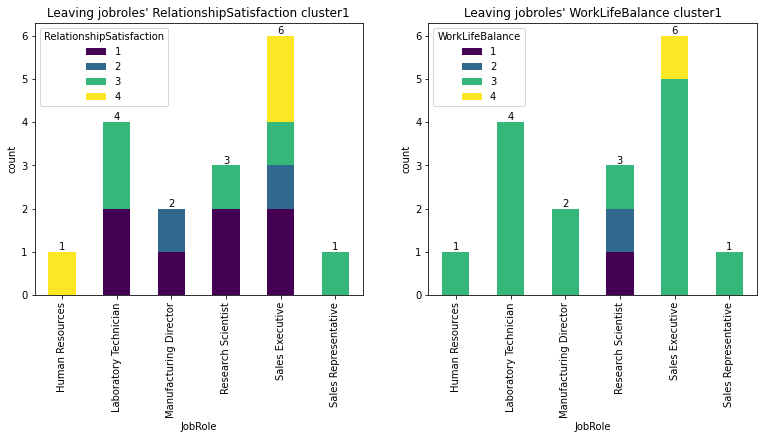

In [136]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "RelationshipSatisfaction", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap,
                                "Leaving jobroles' RelationshipSatisfaction cluster" + str(curr_cluster))
ax = plt.subplot2grid(fig_dims, (0, 1))
draw_stacked_bar(curr_column, "WorkLifeBalance", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)],
                 False, ax, 90, "", curr_cmap,
                                         "Leaving jobroles' WorkLifeBalance cluster" + str(curr_cluster))

<h6> Cluster 2 insight </h6>

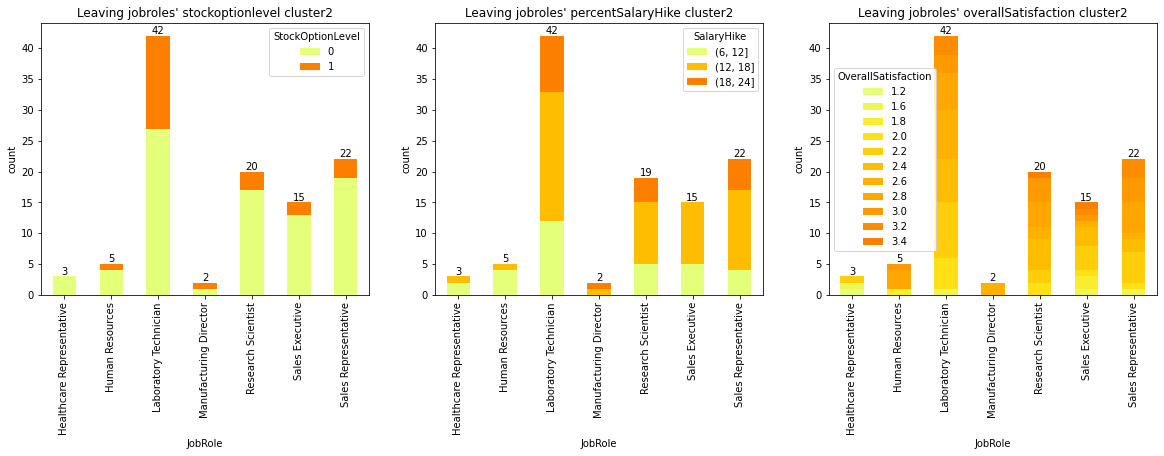

In [137]:
curr_column = "JobRole"
curr_cluster = 2
curr_cmap = "Wistia"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "StockOptionLevel", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"]=="Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' stockoptionlevel cluster" + str(curr_cluster))
 
ax = plt.subplot2grid(fig_dims, (0, 1))
df_hike = df_impunted.copy()
df_hike["SalaryHike"] = pd.cut(x=df_impunted["PercentSalaryHike"], bins=[6, 12, 18, 24])
draw_stacked_bar(curr_column, "SalaryHike", 
                 df_impunted[(df_impunted["Attrition"]=="Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_hike[(df_hike["Attrition"]=="Yes") & (df_hike[cluster_label]==curr_cluster)], 
                 False, ax, 90, "",curr_cmap, "Leaving jobroles' percentSalaryHike cluster" + str(curr_cluster))
ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, "OverallSatisfaction", 
                 df_impunted[(df_impunted["Attrition"]=="Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' overallSatisfaction cluster" + str(curr_cluster))

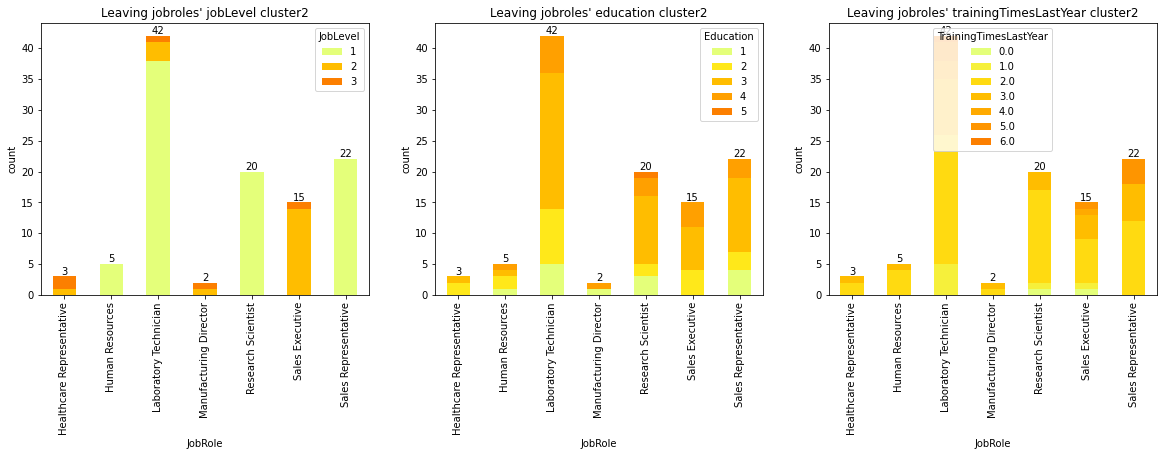

In [138]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "JobLevel", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)],
                False, ax, 90, "", curr_cmap, "Leaving jobroles' jobLevel cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 1))
draw_stacked_bar(curr_column, "Education", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                False, ax, 90, "", curr_cmap, "Leaving jobroles' education cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, "TrainingTimesLastYear", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
    False, ax, 90, "upper center", curr_cmap, "Leaving jobroles' trainingTimesLastYear cluster" + str(curr_cluster))

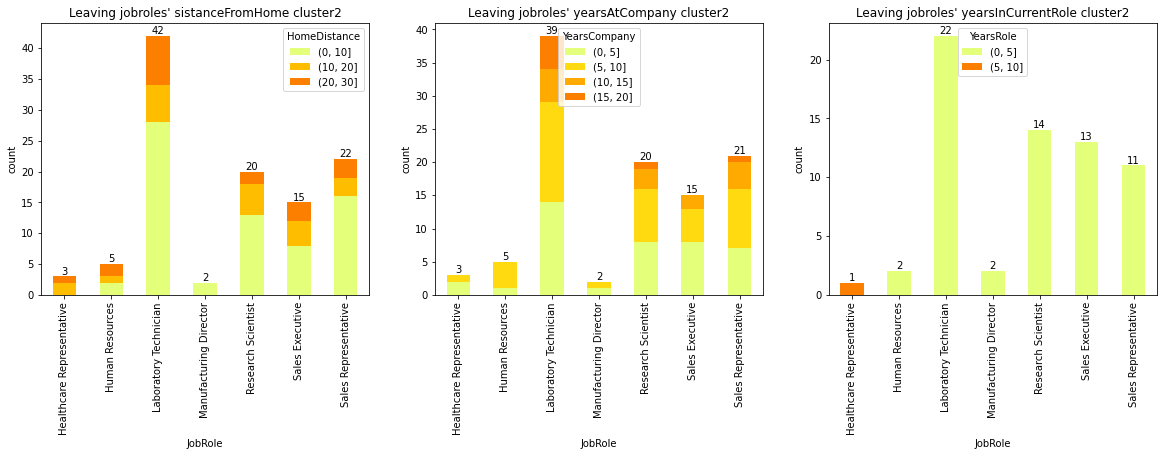

In [139]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
df_dist = df_impunted.copy()
df_dist["HomeDistance"] = pd.cut(x=df_impunted["DistanceFromHome"], bins=[0, 10, 20, 30])
draw_stacked_bar(curr_column, "HomeDistance", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_dist[(df_dist["Attrition"] == "Yes") & (df_dist[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' sistanceFromHome cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 1))
df_yc = df_impunted.copy()
df_yc["YearsCompany"] = pd.cut(x=df_impunted["YearsAtCompany"], bins=[0, 5, 10, 15, 20, 25, 30, 35, 40])
draw_stacked_bar(curr_column, "YearsCompany", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_yc[(df_yc["Attrition"] == "Yes") & (df_yc[cluster_label]==curr_cluster)], 
         False, ax, 90, "upper center", curr_cmap, "Leaving jobroles' yearsAtCompany cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 2))
df_yr = df_impunted.copy()
df_yr["YearsRole"] = pd.cut(x=df_impunted["YearsInCurrentRole"], bins=[0, 5, 10, 15, 20, 25, 30, 35, 40])
draw_stacked_bar(curr_column, "YearsRole", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_yr[(df_yr["Attrition"] == "Yes") & (df_yr[cluster_label]==curr_cluster)], 
    False, ax, 90, "upper center", curr_cmap, "Leaving jobroles' yearsInCurrentRole cluster" + str(curr_cluster))

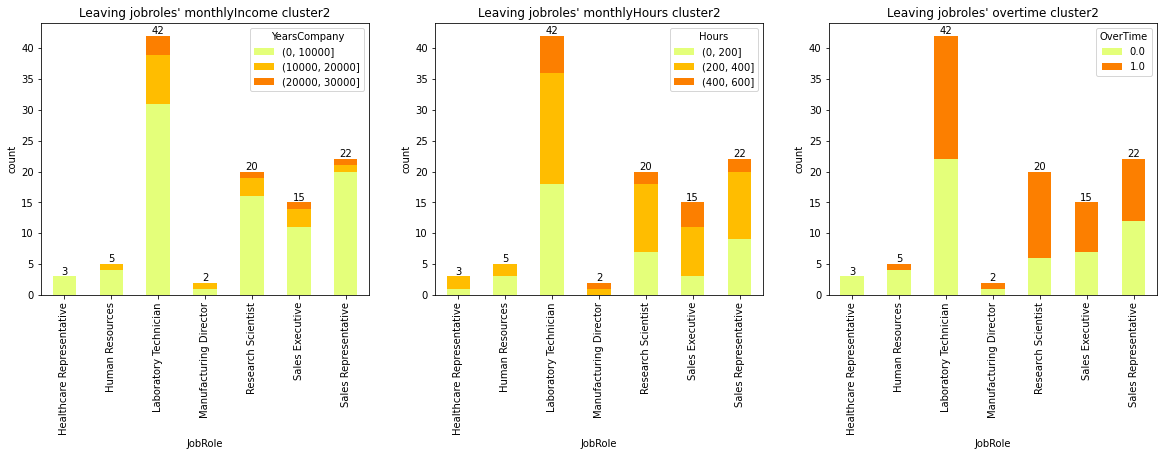

In [140]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
df_income = df_impunted.copy()
df_income["YearsCompany"] = pd.cut(x=df_impunted["MonthlyIncome"], bins=[0, 10000, 20000, 30000])
draw_stacked_bar(curr_column, "YearsCompany", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_income[(df_income["Attrition"] == "Yes") & (df_income[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' monthlyIncome cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 1))
df_h = df_impunted.copy()
df_h["Hours"] = pd.cut(x=df_impunted["MonthlyHours"], bins=[0, 200, 400, 600, 800, 1000])
draw_stacked_bar(curr_column, "Hours",
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_h[(df_h["Attrition"] == "Yes") & (df_h[cluster_label]==curr_cluster)],
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' monthlyHours cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, "OverTime", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_num[(df_num["Attrition"] == 1) & (df_num[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' overtime cluster" + str(curr_cluster))

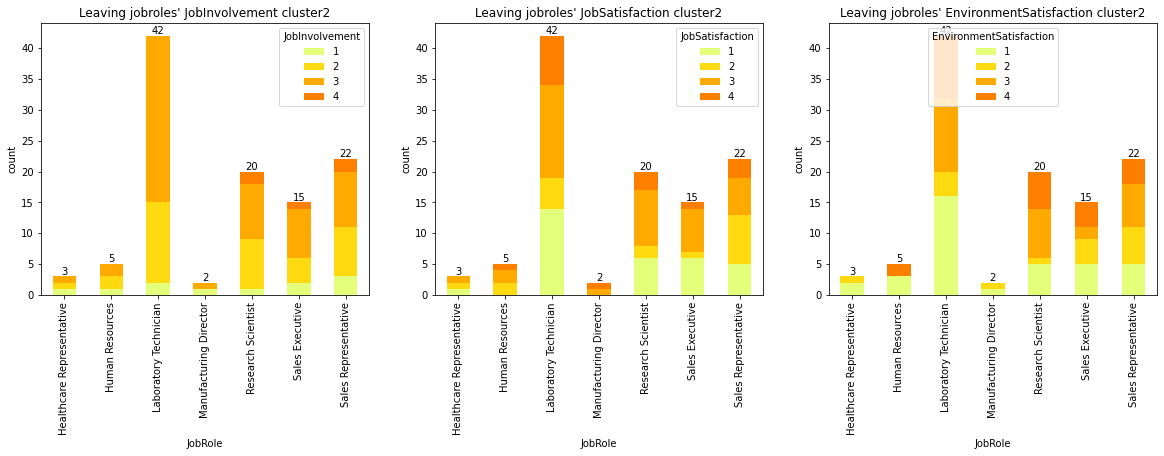

In [141]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "JobInvolvement", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap,
                                                 "Leaving jobroles' JobInvolvement cluster" + str(curr_cluster))
ax = plt.subplot2grid(fig_dims, (0, 1))
draw_stacked_bar(curr_column, "JobSatisfaction", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)],
                 False, ax, 90, "", curr_cmap,
                                            "Leaving jobroles' JobSatisfaction cluster" + str(curr_cluster))
ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, "EnvironmentSatisfaction", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "upper center", curr_cmap,
                                         "Leaving jobroles' EnvironmentSatisfaction cluster" + str(curr_cluster))

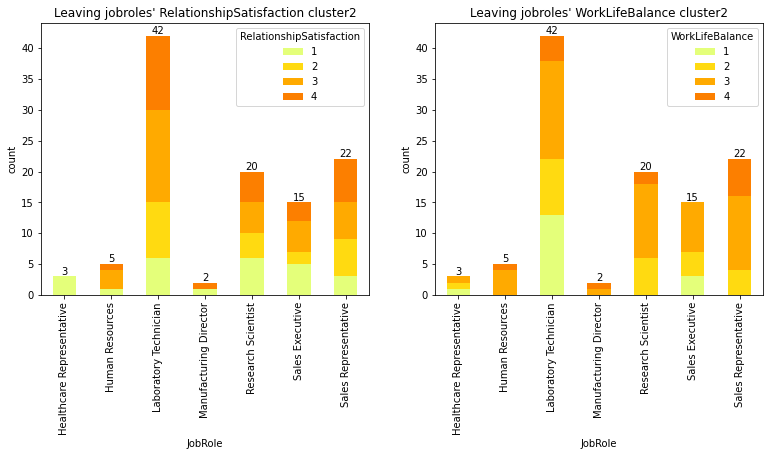

In [142]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "RelationshipSatisfaction", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap,
                                "Leaving jobroles' RelationshipSatisfaction cluster" + str(curr_cluster))
ax = plt.subplot2grid(fig_dims, (0, 1))
draw_stacked_bar(curr_column, "WorkLifeBalance", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)],
                 False, ax, 90, "", curr_cmap,
                                         "Leaving jobroles' WorkLifeBalance cluster" + str(curr_cluster))